## Photonic crystal cavity

Run this notebook in your browser using [Binder](https://mybinder.org/v2/gh/flexcompute-readthedocs/tidy3d-docs/readthedocs?labpath=docs%2Fsource%2Fnotebooks%2FL3_cavity.ipynb).

In this notebook, we will simulate the commonly used L3 photonic crystal cavity composed of three missing holes in a hexagonal lattice of holes in a silicon slab. 

In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt

# tidy3D import
import tidy3d as td
from tidy3d import web

### Coarse simulation

We will first run a broadband simulation to examine the spectrum, and zone in on the fundamental mode of the cavity. We start with defining some general parameters. We will use a fairly low spatial resolution for this initaly simulation. It's worth remembering that the PML extend **beyond** the simulation domain, so we don't need to worry about them covering some of the PhC holes. The one thing we have to remember is to extend the slab through the PML.

In structures with (quasi)-periodicity, that is to say with a well-defined notion of a unit cell, it is usually best to use a grid that is commensurate with the periodicity. This is why here we use a uniform grid in x and y, with a different step size to account for the different periodicity of the PhC lattice in these directions. In z, we use an automatic nonuniform mesh which conforms to the slab thickness and is finer in the silicon region.

In [2]:
# Number of PhC periods in x and y directions
Nx, Ny = 16, 12

# Lattice constant of the PhC in micron
alattice = 0.4

# Regular PhC lattice parameters
ra = 0.25 * alattice # hole radius
d_slab = 0.22        # slab thickness
n_slab = 3.48        # refractive index of the slab

# Materials - air and silicon
air = td.Medium()
si = td.Medium(permittivity=n_slab**2)

# Mesh step in x, y, z, in micron
steps_per_unit_length = 12
grid_spec = td.GridSpec(
    grid_x=td.UniformGrid(dl=alattice / steps_per_unit_length),
    grid_y=td.UniformGrid(dl=alattice / steps_per_unit_length * np.sqrt(3) / 2),
    grid_z=td.AutoGrid(min_steps_per_wvl=steps_per_unit_length)
)

# Central frequency around which we'll look for the cavity mode (Hz)
freq0 = 2e14

# Source bandwidth (Hz)
fwidth = 4e13

# Simulation run time (s)
run_time = 20/fwidth

# Simulation domain size (micron)
sim_size = [(Nx+2)*alattice, ((Ny+1)*alattice)*np.sqrt(3)/2, 4]

Next, we define the positions of the holes that make the photonic crystal structure.

In [3]:
# Define x and y positions in one quadrant of the simulation domain
xp, yp = [], []
nx, ny = Nx//2 + 1, Ny//2 + 1
for iy in range(ny):
    for ix in range(nx):
        xp.append(ix + (iy%2)*0.5)
        yp.append(iy*np.sqrt(3)/2)

# Remove the first two holes to make the L3 defect
xp = xp[2:]
yp = yp[2:]

# Append holes for the other three quadrants
xf, yf = [], []
for x, y in zip(xp, yp):
    xf += [x, x, -x]
    yf += [y, -y, y]
    if x > 0 and y > 0:
        xf += [-x]
        yf += [-y]

Initialize all structures.

In [4]:
slab = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[td.inf, td.inf, d_slab]), 
    medium=si
)

holes = []
for x, y in zip(xf, yf):
    holes.append(
        td.Structure(
            geometry=td.Cylinder(
                center = (np.array([x, y, 0])*alattice).tolist(),
                axis = 2,
                radius = ra,
                length = d_slab
            ),
            medium = air
        )
    )

Initialize the source. We are looking for the fundamental mode of the L3 cavity, so we use a y-polarized  source at the center of the cavity.

In [5]:
source = td.PointDipole(
    center=(0, 0, 0),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth),
    polarization='Ey')

<Figure size 432x288 with 1 Axes>

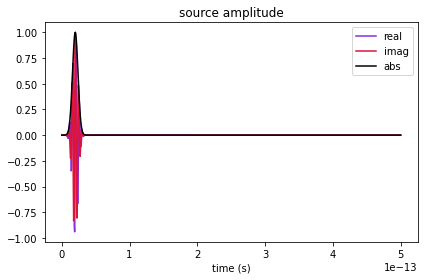

In [6]:
source.source_time.plot(np.linspace(0, run_time, 1001))
plt.show()

Finally, we also place a time monitor in the same location as the source. We set the time monitor starting time to be after the source decay, such that we can exclude the source signature from the recorded spectrum.

In [7]:
t_start = 1e-13
tmonitor = td.FieldTimeMonitor(center=[0, 0, 0], size=[0, 0, 0], start=t_start, name='field')

Initialize the simulation and visualize the structure. By default, Tidy3D will warn you if you have structures too close to the PML, as this can cause instability in the simulation. In photonic crystals this is sometimes inevitable, however, and it is OK in this case because the fields of the cavity mode are strongly localized around the center of the simulation domain.

In [8]:
# Suppress warnings for some of the holes being too close to the PML
td.logging_level = 'error'

sim = td.Simulation(
    size=sim_size, 
    grid_spec=grid_spec, 
    structures=[slab]+holes, 
    sources=[source],
    monitors=[tmonitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())
)

[10:52:35] WARNING  Structure at structures[16] was detected as being less  ]8;id=8432;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=106711;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[17] was detected as being less  ]8;id=510763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=785969;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[18] was detected as being less  ]8;id=942376;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=280199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[19] was detected as being less  ]8;id=329304;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=576315;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

[10:52:36] WARNING  Structure at structures[20] was detected as being less  ]8;id=697095;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=946379;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[21] was detected as being less  ]8;id=729032;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=606431;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[50] was detected as being less  ]8;id=995815;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=480323;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[51] was detected as being less  ]8;id=119318;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=45748;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[52] was detected as being less  ]8;id=380416;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=920409;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[53] was detected as being less  ]8;id=925760;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=968307;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[54] was detected as being less  ]8;id=385667;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=235963;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[55] was detected as being less  ]8;id=581540;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=325041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[56] was detected as being less  ]8;id=548356;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=561894;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[57] was detected as being less  ]8;id=787597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=955456;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[85] was detected as being less  ]8;id=404677;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=350554;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[86] was detected as being less  ]8;id=698731;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=184867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[87] was detected as being less  ]8;id=692850;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=371883;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[88] was detected as being less  ]8;id=631395;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=205336;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[89] was detected as being less  ]8;id=783598;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=71249;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[90] was detected as being less  ]8;id=199420;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=800175;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[91] was detected as being less  ]8;id=540100;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=96156;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[92] was detected as being less  ]8;id=475956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=34964;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[121] was detected as being less ]8;id=681800;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=739969;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[122] was detected as being less ]8;id=87324;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=100738;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[123] was detected as being less ]8;id=914988;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=304716;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[124] was detected as being less ]8;id=136414;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=671015;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[125] was detected as being less ]8;id=922570;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=316063;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[126] was detected as being less ]8;id=391497;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=416557;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[127] was detected as being less ]8;id=197585;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=676432;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[128] was detected as being less ]8;id=943763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=743899;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=595075;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=460998;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=495617;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=612057;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=655782;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=745233;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=702321;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=930489;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=321112;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=211838;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=582783;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=838277;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=23948;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=117383;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=135145;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=432351;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[164] was detected as being less ]8;id=820267;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=10402;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[165] was detected as being less ]8;id=874200;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=566129;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[166] was detected as being less ]8;id=908056;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=58010;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[167] was detected as being less ]8;id=482421;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=22084;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[168] was detected as being less ]8;id=105201;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=341164;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[169] was detected as being less ]8;id=63321;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=212120;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[170] was detected as being less ]8;id=476792;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=954126;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[171] was detected as being less ]8;id=935398;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=862909;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[172] was detected as being less ]8;id=195418;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=38388;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[173] was detected as being less ]8;id=947262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=378162;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[174] was detected as being less ]8;id=230330;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=421011;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[175] was detected as being less ]8;id=624161;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=147739;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[176] was detected as being less ]8;id=727519;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=84765;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[177] was detected as being less ]8;id=578505;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=652364;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[178] was detected as being less ]8;id=520660;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=901227;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[179] was detected as being less ]8;id=840827;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=591041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[180] was detected as being less ]8;id=608049;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=997522;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[181] was detected as being less ]8;id=81308;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=251346;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[182] was detected as being less ]8;id=662670;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=712548;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[183] was detected as being less ]8;id=44262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=499404;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[184] was detected as being less ]8;id=336809;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=230836;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[185] was detected as being less ]8;id=409832;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=521825;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[186] was detected as being less ]8;id=177009;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=336426;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[187] was detected as being less ]8;id=456930;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=997568;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[188] was detected as being less ]8;id=381036;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=513346;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[189] was detected as being less ]8;id=633946;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=908669;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[190] was detected as being less ]8;id=224062;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=948230;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[191] was detected as being less ]8;id=106728;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=333354;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=776135;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=850241;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=831462;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=697199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=850870;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=387077;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=990345;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=792645;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=297360;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=668560;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=181613;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=392879;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=51235;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=249854;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=81447;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=892985;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=65739;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=244296;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=552509;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=85074;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=110406;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=479218;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=530216;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=740392;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=917859;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=805551;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=380883;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=167004;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=665348;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=78040;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=470991;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=275623;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[200] was detected as being less ]8;id=193488;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=517276;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[201] was detected as being less ]8;id=29701;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=346815;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[202] was detected as being less ]8;id=728377;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=490048;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[203] was detected as being less ]8;id=979608;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=886172;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[204] was detected as being less ]8;id=80629;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=890193;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[205] was detected as being less ]8;id=644609;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=277340;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[206] was detected as being less ]8;id=688934;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=256080;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[207] was detected as being less ]8;id=444493;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=853063;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[208] was detected as being less ]8;id=684080;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=838161;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[209] was detected as being less ]8;id=195071;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=174072;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[210] was detected as being less ]8;id=841656;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=269710;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[211] was detected as being less ]8;id=874501;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=973722;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[212] was detected as being less ]8;id=803453;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=115750;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[213] was detected as being less ]8;id=651465;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=118623;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[214] was detected as being less ]8;id=447692;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=731436;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[215] was detected as being less ]8;id=479844;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=594817;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[216] was detected as being less ]8;id=779164;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=401989;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[217] was detected as being less ]8;id=898850;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=300157;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[218] was detected as being less ]8;id=808225;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=804558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[219] was detected as being less ]8;id=186738;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=711386;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[220] was detected as being less ]8;id=260540;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=596199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[221] was detected as being less ]8;id=459837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=760833;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[222] was detected as being less ]8;id=48107;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=92817;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[223] was detected as being less ]8;id=892037;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=213016;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[224] was detected as being less ]8;id=879903;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=380349;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[225] was detected as being less ]8;id=241269;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=143612;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[226] was detected as being less ]8;id=778152;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=601291;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=314146;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=896133;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=986598;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=534803;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=751238;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=762286;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=53677;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=669766;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=164488;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=317470;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=563313;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=551587;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=420999;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=935714;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=156499;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=634937;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=572452;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=887993;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=524910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=899791;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=391166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=981211;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=889634;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=122255;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=354041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=466725;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=905237;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=753690;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=40775;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=945381;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=294834;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=648728;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           INFO     Auto meshing using wavelength 1.4990 defined from        ]8;id=963095;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=91980;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#478\478]8;;\
                    sources.                                                                 

<Figure size 864x288 with 4 Axes>

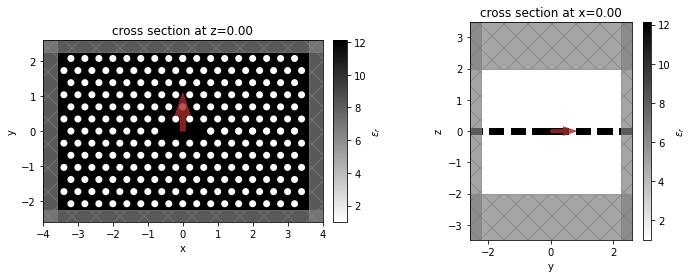

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim.plot_eps(z=0, ax=ax[0]);
sim.plot_eps(x=0, ax=ax[1]);

### Run simulation and examine the spectrum

Now that the simulation is constructed, we can run it using the `web` API of Tidy3D. First, we submit the project.

In [10]:
# Submit a project to the cluster
job = web.Job(simulation=sim, task_name='L3 low res')
job.upload()
job.start()

[10:52:37] INFO     Using Tidy3D credentials from stored file                      ]8;id=83453;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py\auth.py]8;;\:]8;id=603997;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/auth.py#74\74]8;;\

[10:52:39] INFO     Uploaded task 'L3 low res' with task_id                     ]8;id=735230;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=905372;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    'e3f1d0ae-fe6d-4dd6-a19b-6692735fa857'.                                  

And we can continuously monitor the status until the run is succsessful.

In [11]:
job.monitor()

[10:52:44] INFO     Maximum flex unit cost: 0.20                                ]8;id=894993;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=492283;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                             ]8;id=61525;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=170094;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[10:53:00] INFO     status = preprocess                                         ]8;id=106556;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=477715;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[10:53:14] INFO     starting up solver                                          ]8;id=201266;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=389364;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[10:53:35] INFO     running solver                                              ]8;id=296526;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=594505;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

           INFO     status = postprocess                                        ]8;id=133043;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=302199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[10:53:52] INFO     status = success                                            ]8;id=447913;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=808844;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

Once the run is successful, we can download the results and load them in the `td.SimulationData` object.

In [12]:
sim_data = job.load(path='data/sim_data.hdf5')

[10:53:54] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=162620;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=514752;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#584\584]8;;\
                    "data/sim_data.hdf5"                                                     

Output()

[10:53:55] INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=392719;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=555577;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#407\407]8;;\

           WARNING  Structure at structures[16] was detected as being less  ]8;id=77777;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=862110;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[17] was detected as being less  ]8;id=376513;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=387303;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[18] was detected as being less  ]8;id=342390;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=745276;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[19] was detected as being less  ]8;id=62166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=816968;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[20] was detected as being less  ]8;id=339318;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=203575;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[21] was detected as being less  ]8;id=699907;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=953353;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[50] was detected as being less  ]8;id=812263;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=63527;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[51] was detected as being less  ]8;id=435574;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=999321;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[52] was detected as being less  ]8;id=983664;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=511018;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[53] was detected as being less  ]8;id=231835;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=547208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[54] was detected as being less  ]8;id=61732;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=249846;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[55] was detected as being less  ]8;id=737945;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=216451;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[56] was detected as being less  ]8;id=975160;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=635327;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[57] was detected as being less  ]8;id=51462;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=26539;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[85] was detected as being less  ]8;id=84124;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=913100;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[86] was detected as being less  ]8;id=824672;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=344713;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[87] was detected as being less  ]8;id=37101;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=429478;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[88] was detected as being less  ]8;id=711114;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=152166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[89] was detected as being less  ]8;id=859839;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=414585;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[90] was detected as being less  ]8;id=409684;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=545941;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[91] was detected as being less  ]8;id=493372;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=638938;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[92] was detected as being less  ]8;id=435955;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=341732;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[121] was detected as being less ]8;id=899385;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=773365;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[122] was detected as being less ]8;id=127560;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=320927;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[123] was detected as being less ]8;id=260250;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=576095;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[124] was detected as being less ]8;id=40867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=374584;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[125] was detected as being less ]8;id=914865;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=124745;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[126] was detected as being less ]8;id=680334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=962899;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[127] was detected as being less ]8;id=908680;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=730837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[128] was detected as being less ]8;id=602365;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=242704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=265635;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=854812;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=836957;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=206445;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=435211;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=121607;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=659996;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=945743;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=894827;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=575416;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=586180;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=815701;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=22723;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=997531;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=981620;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=845041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[164] was detected as being less ]8;id=75172;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=713387;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[165] was detected as being less ]8;id=591952;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=866262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[166] was detected as being less ]8;id=652510;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=504557;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[167] was detected as being less ]8;id=333692;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=964702;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[168] was detected as being less ]8;id=985350;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=30035;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[169] was detected as being less ]8;id=628110;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=244438;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[170] was detected as being less ]8;id=673677;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=311944;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[171] was detected as being less ]8;id=302983;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=269983;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[172] was detected as being less ]8;id=843307;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=27967;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[173] was detected as being less ]8;id=746528;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=561558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[174] was detected as being less ]8;id=921155;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=671820;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[175] was detected as being less ]8;id=829960;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=788247;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[176] was detected as being less ]8;id=634373;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=938417;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[177] was detected as being less ]8;id=118456;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=810863;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[178] was detected as being less ]8;id=937265;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=159446;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[179] was detected as being less ]8;id=250614;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=572665;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[180] was detected as being less ]8;id=543532;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=382688;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[181] was detected as being less ]8;id=781169;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=401837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[182] was detected as being less ]8;id=938756;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=339549;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[183] was detected as being less ]8;id=839414;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=515883;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[184] was detected as being less ]8;id=406959;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=604054;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[185] was detected as being less ]8;id=195254;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=353584;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[186] was detected as being less ]8;id=726403;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=53184;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[187] was detected as being less ]8;id=826912;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=696531;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[188] was detected as being less ]8;id=366751;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=530319;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[189] was detected as being less ]8;id=373666;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=254345;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[190] was detected as being less ]8;id=527488;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=198590;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[191] was detected as being less ]8;id=803862;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=485905;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=448597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=570081;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=618165;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=210729;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=487583;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=180632;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=523808;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=476559;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=796430;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=157250;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=30218;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=692943;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=622966;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=605558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=321146;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=926809;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=798182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=304212;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=216114;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=411257;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=432123;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=78722;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=4169;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=442736;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=689551;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=700806;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=500543;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=831109;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=567227;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=420537;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=958597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=274964;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[200] was detected as being less ]8;id=354201;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=631713;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[201] was detected as being less ]8;id=19383;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=373952;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[202] was detected as being less ]8;id=6584;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=446743;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[203] was detected as being less ]8;id=166209;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=838791;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[204] was detected as being less ]8;id=211734;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=890690;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[205] was detected as being less ]8;id=274127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=344649;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[206] was detected as being less ]8;id=704389;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=330798;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[207] was detected as being less ]8;id=97829;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=209076;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[208] was detected as being less ]8;id=650003;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=21856;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[209] was detected as being less ]8;id=16809;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=364276;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[210] was detected as being less ]8;id=66788;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=94670;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[211] was detected as being less ]8;id=136210;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=165394;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[212] was detected as being less ]8;id=523336;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=387444;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[213] was detected as being less ]8;id=624587;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=657230;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[214] was detected as being less ]8;id=45772;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=170795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[215] was detected as being less ]8;id=161794;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=646795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[216] was detected as being less ]8;id=403192;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=114182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[217] was detected as being less ]8;id=803700;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=459789;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[218] was detected as being less ]8;id=792877;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=82243;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[219] was detected as being less ]8;id=970824;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=574362;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[220] was detected as being less ]8;id=529515;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=793759;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[221] was detected as being less ]8;id=263554;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=381564;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[222] was detected as being less ]8;id=813411;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=363415;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[223] was detected as being less ]8;id=785646;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=971941;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[224] was detected as being less ]8;id=549787;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=758108;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[225] was detected as being less ]8;id=237966;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=352039;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[226] was detected as being less ]8;id=495740;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=708570;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=140795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=290510;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=699014;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=505345;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=328555;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=916893;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=817493;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=411644;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=728877;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=597841;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=745526;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=250133;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=349862;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=76031;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=983251;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=405166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=139314;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=548452;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=278985;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=562501;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=582262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=18602;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=714835;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=583627;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=216280;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=825139;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=964017;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=998650;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=432964;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=282182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=309967;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=256492;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Simulation final field decay value of 0.0724 is greater     ]8;id=616384;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=367005;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#413\413]8;;\
                    than the simulation shutoff threshold of 1e-05. Consider                 
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

We finally plot the time dependence of the field in the center of the cavity, and the spectrum computed using a Fourier transform of that field. For the latter, we use the in-built `dft_spectrum` function.

<Figure size 720x216 with 2 Axes>

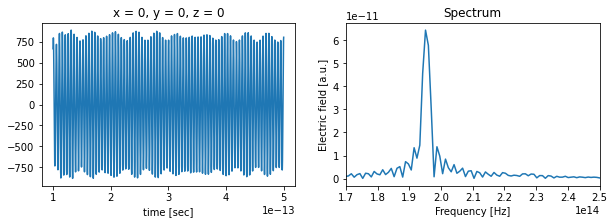

In [13]:
# Get data from the TimeMonitor
tdata = sim_data['field']

time_series = tdata.Ey.interp(x=0, y=0, z=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

# Plot time dependence 
time_series.plot(ax=ax1)
# ax[0].set_xlabel("Time [s]")
# ax[0].set_ylabel("Electric field [a.u.]");
# ax[0].set_title("Ey vs. time")

# Make frequency mesh and plot spectrum
dt = sim_data.simulation.dt
fmesh = np.linspace(1.6e14, 2.5e14, 101)

dft_matrix = np.exp(2j * np.pi * fmesh[:, None] * time_series.t.values) / np.sqrt(2 * np.pi)
spectrum = dt * dft_matrix @ np.real(time_series.values)

ax2.plot(fmesh, np.abs(spectrum))
ax2.set_xlim(1.7e14, 2.5e14)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Electric field [a.u.]");
ax2.set_title("Spectrum");

We see a big peak close to `f = 195THz`, which is most likely what we are looking for, because a) the fundamental mode is the longest-lived and b) we use a y-polarized source at the center of the simulation domain, which does not excite some of the other modes. Next, we refine the simulation and compute the field profile of this fundamental mode.

### Refine simulation, apply symmetries, get mode profile

Now that we've seen a clear resonant peak, we can increase the resolution of the simulation to obtain more accurate results, and to get a high-resolution image of the cavity mode. We center the source frequency close to the peak of the spectrum above, and decrease the bandwidth to exclude any other modes. We will also double the spatial resolution, making it 20 pixels per lattice period. Finally, we will also incorporate symmetries to speed up the computation.

In [14]:
# New target frequency based on spectrum above
freq0 = 1.95e14

# Narrow-bandwidth source
source = td.PointDipole(
    center=(0, 0, 0),
    source_time=td.GaussianPulse(
        freq0=freq0,
        fwidth=fwidth/5),
    polarization='Ey')

# Also increase the run time a bit
run_time = 50/fwidth

# 20 pixels per lattice period
steps_per_unit_length = 20
grid_spec = td.GridSpec(
    grid_x=td.UniformGrid(dl=alattice / steps_per_unit_length),
    grid_y=td.UniformGrid(dl=alattice / steps_per_unit_length * np.sqrt(3) / 2),
    grid_z=td.AutoGrid(min_steps_per_wvl=steps_per_unit_length)
)

We can use both a time and a frequency monitor to obtain the field profile, each coming with advantages and disadvantages. The frequency monitor captures accurately the frequency-domain field, but that includes the source signature. On the other hand, examining the time-domain field can capture the "eigenmode" of the system, but only if all the other modes have decayed. This is, to a very large extent, the case in our simulation, so as we'll see the second approach works very well.

**NB**: An important thing to note is that a 2D time monitor can result in a very large amount of data. Because of this, we will only record the fields near the last time step, setting `start = run_time` in the `FieldTimeMonitor`.

In [15]:
# Time and frequency monitors
tmonitor = td.FieldTimeMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    start=run_time,
    name='final_time')

fmonitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[4, 2*np.sqrt(3), 0],
    freqs=[freq0],
    name='field')

We initialize the simulation with reflection symmetries defined with respect to the x-, y-, and z-planes. Note that the eigenvalue of the symmetry (plus or minus one) has to be carefully determined, taking into account the vectorial nature of the electric field (and the pseudo-vector nature of the magnetic field). As an extra hint, positive symmetry is equivalent to a PMC plane, where the normal E-field component vanishes, while negative symmetry is equivalent to a PEC plane, where the parallel components of the E-field vanish. The symmetry values can be determined by thinking about a y-polarized electric dipole at the origin: `(1, -1, 1)`.

In [16]:
# Initialize simulation
sim = td.Simulation(
    size=sim_size, 
    grid_spec=grid_spec, 
    structures=[slab]+holes, 
    sources=[source], 
    monitors=[tmonitor, fmonitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    symmetry=(1, -1, 1),
)

[10:53:56] WARNING  Structure at structures[16] was detected as being less  ]8;id=728808;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=920480;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[17] was detected as being less  ]8;id=959268;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=660342;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[18] was detected as being less  ]8;id=185768;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=776988;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[19] was detected as being less  ]8;id=370059;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=699508;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[20] was detected as being less  ]8;id=634977;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=118216;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[21] was detected as being less  ]8;id=61309;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=200153;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[50] was detected as being less  ]8;id=136782;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=867397;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[51] was detected as being less  ]8;id=432830;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=578604;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[52] was detected as being less  ]8;id=476264;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=264738;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[53] was detected as being less  ]8;id=13774;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=273904;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[54] was detected as being less  ]8;id=29390;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=638972;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[55] was detected as being less  ]8;id=862218;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=233863;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[56] was detected as being less  ]8;id=755067;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=752725;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[57] was detected as being less  ]8;id=267294;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=486586;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[85] was detected as being less  ]8;id=123211;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=5203;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[86] was detected as being less  ]8;id=544728;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=464541;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[87] was detected as being less  ]8;id=403804;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=819217;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[88] was detected as being less  ]8;id=635887;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=780042;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[89] was detected as being less  ]8;id=182892;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=398754;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[90] was detected as being less  ]8;id=82550;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=992382;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[91] was detected as being less  ]8;id=114477;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=148709;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[92] was detected as being less  ]8;id=373143;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=722424;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[121] was detected as being less ]8;id=847000;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=622476;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[122] was detected as being less ]8;id=323769;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=979509;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[123] was detected as being less ]8;id=294140;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=369951;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[124] was detected as being less ]8;id=391697;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=412397;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[125] was detected as being less ]8;id=890226;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=180396;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[126] was detected as being less ]8;id=328279;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=118558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[127] was detected as being less ]8;id=600597;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=886443;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[128] was detected as being less ]8;id=150476;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=633581;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[129] was detected as being less ]8;id=872075;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=919180;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[130] was detected as being less ]8;id=489860;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=840947;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[131] was detected as being less ]8;id=769479;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=221098;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[132] was detected as being less ]8;id=614352;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=222759;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[133] was detected as being less ]8;id=774265;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=122089;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[134] was detected as being less ]8;id=842745;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=967044;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[135] was detected as being less ]8;id=478197;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=809952;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[136] was detected as being less ]8;id=25341;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=953641;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[137] was detected as being less ]8;id=756325;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=133489;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[138] was detected as being less ]8;id=913879;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=450146;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[139] was detected as being less ]8;id=861474;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=644444;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[140] was detected as being less ]8;id=638565;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=529023;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[141] was detected as being less ]8;id=200760;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=615041;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[142] was detected as being less ]8;id=301686;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=165546;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[143] was detected as being less ]8;id=374229;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=187874;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[144] was detected as being less ]8;id=763020;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=306066;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[145] was detected as being less ]8;id=544665;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=614524;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[146] was detected as being less ]8;id=789114;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=974732;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[147] was detected as being less ]8;id=10526;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=625622;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[148] was detected as being less ]8;id=708268;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=620479;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[149] was detected as being less ]8;id=323258;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=275566;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[150] was detected as being less ]8;id=578599;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=661077;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[151] was detected as being less ]8;id=631910;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=617367;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[152] was detected as being less ]8;id=520285;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=574117;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[153] was detected as being less ]8;id=11315;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=674348;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[154] was detected as being less ]8;id=225133;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=662437;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[155] was detected as being less ]8;id=709607;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=956084;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=692490;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=286552;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=823048;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=385619;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=515778;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=87611;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=754086;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=811433;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=194340;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=5735;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=82595;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=574255;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=427277;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=522082;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=334753;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=50594;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=779127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=283182;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=429225;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=50399;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=598390;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=717515;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=145113;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=305138;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=169939;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=386948;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=925027;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=304989;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=20783;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=881188;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=333866;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=80057;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[164] was detected as being less ]8;id=443107;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=591266;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[165] was detected as being less ]8;id=801326;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=357253;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[166] was detected as being less ]8;id=497839;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=828283;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[167] was detected as being less ]8;id=214733;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=402355;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[168] was detected as being less ]8;id=885635;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=98127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[169] was detected as being less ]8;id=24893;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=152113;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[170] was detected as being less ]8;id=883034;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=176122;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[171] was detected as being less ]8;id=66536;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=135545;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[172] was detected as being less ]8;id=706958;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=243901;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[173] was detected as being less ]8;id=956610;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=758650;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[174] was detected as being less ]8;id=457914;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=770211;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[175] was detected as being less ]8;id=249794;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=758207;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[176] was detected as being less ]8;id=169944;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=497805;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[177] was detected as being less ]8;id=211447;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=13558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[178] was detected as being less ]8;id=396466;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=457539;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[179] was detected as being less ]8;id=719562;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=311030;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[180] was detected as being less ]8;id=63759;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=746349;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[181] was detected as being less ]8;id=79437;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=829971;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[182] was detected as being less ]8;id=928519;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=495867;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[183] was detected as being less ]8;id=587020;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=253737;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[184] was detected as being less ]8;id=967449;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=196305;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[185] was detected as being less ]8;id=71924;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=686707;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[186] was detected as being less ]8;id=968901;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=708590;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[187] was detected as being less ]8;id=690895;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=348576;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[188] was detected as being less ]8;id=58744;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=96571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[189] was detected as being less ]8;id=492754;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=708267;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[190] was detected as being less ]8;id=273625;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=822233;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[191] was detected as being less ]8;id=854918;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=34431;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=793699;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=423868;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=968233;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=774206;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=404037;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=348708;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=327013;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=100111;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=477238;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=764580;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=297491;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=589110;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=623500;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=149337;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=767538;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=659548;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=446693;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=409912;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=139547;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=659044;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=600062;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=940185;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=922043;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=343265;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=280036;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=270636;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=452369;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=285229;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=135127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=9376;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=883034;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=621467;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[200] was detected as being less ]8;id=67252;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=320314;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[201] was detected as being less ]8;id=394286;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=813484;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[202] was detected as being less ]8;id=735837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=898933;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[203] was detected as being less ]8;id=125545;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=743173;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[204] was detected as being less ]8;id=156069;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=824743;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[205] was detected as being less ]8;id=140460;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=12691;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[206] was detected as being less ]8;id=794657;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=322514;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[207] was detected as being less ]8;id=848774;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=43422;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[208] was detected as being less ]8;id=246674;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=398908;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[209] was detected as being less ]8;id=421385;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=180700;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[210] was detected as being less ]8;id=567808;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=45498;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[211] was detected as being less ]8;id=424464;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=723776;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[212] was detected as being less ]8;id=853377;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=833262;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[213] was detected as being less ]8;id=575562;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=195059;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[214] was detected as being less ]8;id=847233;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=843763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[215] was detected as being less ]8;id=967724;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=84395;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[216] was detected as being less ]8;id=414662;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=417879;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[217] was detected as being less ]8;id=383804;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=139244;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[218] was detected as being less ]8;id=453109;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=304433;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[219] was detected as being less ]8;id=213516;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=532729;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[220] was detected as being less ]8;id=719247;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=253846;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[221] was detected as being less ]8;id=308;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=617325;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[222] was detected as being less ]8;id=702904;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=804828;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[223] was detected as being less ]8;id=81102;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=201895;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[224] was detected as being less ]8;id=653147;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=945168;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[225] was detected as being less ]8;id=585532;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=65660;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[226] was detected as being less ]8;id=601121;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=190368;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=305623;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=136268;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=540650;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=841770;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=994583;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=37558;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=423977;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=609721;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=1716;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=81954;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=799496;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=286599;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=135725;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=378815;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=353652;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=327649;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=315510;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=372645;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=376245;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=674035;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=727137;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=90440;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=751462;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=237001;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=999898;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=126050;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=998322;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=972334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=511776;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=610242;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=967091;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=414571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           INFO     Auto meshing using wavelength 1.5374 defined from        ]8;id=408065;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py\grid_spec.py]8;;\:]8;id=801139;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/grid/grid_spec.py#478\478]8;;\
                    sources.                                                                 

<Figure size 576x432 with 2 Axes>

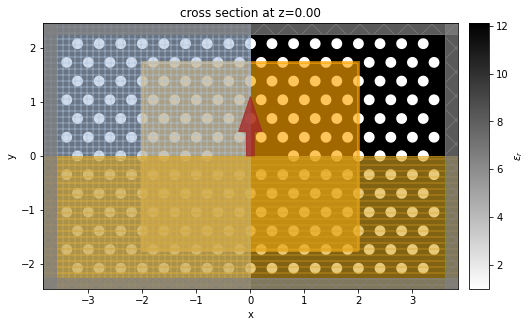

In [17]:
fig, ax = plt.subplots(1, figsize=(8, 6))
sim.plot_eps(z=0, ax=ax);

We run the simulation as above.

In [18]:
sim_data = web.run(sim, task_name='L3 high res', path='data/sim_data.hdf5')

[10:53:59] INFO     Uploaded task 'L3 high res' with task_id                    ]8;id=995670;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=570039;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#120\120]8;;\
                    '81244267-bb50-429a-85a1-38f3e15d7611'.                                  

[10:54:04] INFO     Maximum flex unit cost: 0.20                                ]8;id=328425;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=352855;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#253\253]8;;\

           INFO     status = queued                                             ]8;id=648011;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=947324;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#262\262]8;;\

Output()

[10:54:19] INFO     status = preprocess                                         ]8;id=284208;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=664323;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#274\274]8;;\

[10:54:33] INFO     starting up solver                                          ]8;id=475135;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=383116;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#278\278]8;;\

[10:54:47] INFO     running solver                                              ]8;id=740009;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=245808;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#284\284]8;;\

Output()

[10:54:59] INFO     early shutoff detected, exiting.                            ]8;id=433052;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=655038;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#295\295]8;;\

           INFO     status = postprocess                                        ]8;id=156296;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=338630;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#301\301]8;;\

Output()

[10:55:16] INFO     status = success                                            ]8;id=488776;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=132763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#307\307]8;;\

[10:55:18] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=385899;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=13996;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#584\584]8;;\
                    "data/sim_data.hdf5"                                                     

Output()

[10:55:19] INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=45581;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=946385;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#407\407]8;;\

           WARNING  Structure at structures[16] was detected as being less  ]8;id=93029;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=74052;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[17] was detected as being less  ]8;id=686136;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=944641;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[18] was detected as being less  ]8;id=758734;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=605213;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[19] was detected as being less  ]8;id=584704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=455062;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[20] was detected as being less  ]8;id=429391;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=434936;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[21] was detected as being less  ]8;id=42962;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=793814;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[50] was detected as being less  ]8;id=941366;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=643707;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[51] was detected as being less  ]8;id=420916;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=278197;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[52] was detected as being less  ]8;id=226392;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=546110;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[53] was detected as being less  ]8;id=199423;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=896648;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[54] was detected as being less  ]8;id=835458;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=632674;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[55] was detected as being less  ]8;id=134704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=948132;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[56] was detected as being less  ]8;id=183388;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=831567;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[57] was detected as being less  ]8;id=921835;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=262521;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[85] was detected as being less  ]8;id=415940;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=483292;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[86] was detected as being less  ]8;id=706199;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=86546;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[87] was detected as being less  ]8;id=990395;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=148864;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[88] was detected as being less  ]8;id=971119;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=107461;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[89] was detected as being less  ]8;id=230409;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=872121;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[90] was detected as being less  ]8;id=730648;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=509697;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[91] was detected as being less  ]8;id=835931;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=827641;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[92] was detected as being less  ]8;id=759829;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=574613;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[121] was detected as being less ]8;id=2353;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=155961;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[122] was detected as being less ]8;id=189359;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=631589;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[123] was detected as being less ]8;id=851971;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=733310;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[124] was detected as being less ]8;id=453751;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=826615;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[125] was detected as being less ]8;id=49927;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=55520;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[126] was detected as being less ]8;id=700016;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=523414;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[127] was detected as being less ]8;id=637871;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=229207;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[128] was detected as being less ]8;id=710358;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=689151;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[129] was detected as being less ]8;id=514178;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=531651;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[130] was detected as being less ]8;id=51313;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=243814;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[131] was detected as being less ]8;id=342946;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=640600;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[132] was detected as being less ]8;id=71398;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=34412;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[133] was detected as being less ]8;id=806229;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=457055;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[134] was detected as being less ]8;id=110282;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=703953;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[135] was detected as being less ]8;id=47220;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=715570;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[136] was detected as being less ]8;id=243209;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=868201;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[137] was detected as being less ]8;id=275751;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=692390;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[138] was detected as being less ]8;id=158207;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=970769;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[139] was detected as being less ]8;id=709491;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=734810;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[140] was detected as being less ]8;id=895805;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=624168;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[141] was detected as being less ]8;id=994520;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=161302;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[142] was detected as being less ]8;id=574421;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=23795;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[143] was detected as being less ]8;id=348073;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=399427;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[144] was detected as being less ]8;id=980650;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=648482;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[145] was detected as being less ]8;id=836067;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=281379;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[146] was detected as being less ]8;id=74128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=84517;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[147] was detected as being less ]8;id=958534;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=607821;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[148] was detected as being less ]8;id=235881;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=238520;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[149] was detected as being less ]8;id=721758;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=987917;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[150] was detected as being less ]8;id=722295;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=506807;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[151] was detected as being less ]8;id=23471;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=527892;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[152] was detected as being less ]8;id=965270;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=648100;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[153] was detected as being less ]8;id=445940;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=866406;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[154] was detected as being less ]8;id=829784;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=363974;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[155] was detected as being less ]8;id=793718;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=360720;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=465765;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=784439;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[156] was detected as being less ]8;id=696330;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=364370;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=890083;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=707303;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[157] was detected as being less ]8;id=160652;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=136151;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=636592;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=297491;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[158] was detected as being less ]8;id=496415;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=924184;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=996369;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=438713;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[159] was detected as being less ]8;id=783721;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=240603;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=238084;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=379507;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[160] was detected as being less ]8;id=554742;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=105246;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=642151;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=924649;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[161] was detected as being less ]8;id=885063;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=489802;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=96033;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=106444;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[162] was detected as being less ]8;id=913939;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=8653;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=30763;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=628655;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[163] was detected as being less ]8;id=331515;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=213023;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[164] was detected as being less ]8;id=203921;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=509771;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[165] was detected as being less ]8;id=163556;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=931314;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[166] was detected as being less ]8;id=988273;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=939534;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[167] was detected as being less ]8;id=334624;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=262531;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[168] was detected as being less ]8;id=257571;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=625727;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[169] was detected as being less ]8;id=477255;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=171069;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[170] was detected as being less ]8;id=596350;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=978459;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[171] was detected as being less ]8;id=856029;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=872371;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[172] was detected as being less ]8;id=120912;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=723511;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[173] was detected as being less ]8;id=374427;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=871865;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[174] was detected as being less ]8;id=785226;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=573423;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[175] was detected as being less ]8;id=813780;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=829465;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[176] was detected as being less ]8;id=184717;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=395842;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[177] was detected as being less ]8;id=975628;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=974554;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[178] was detected as being less ]8;id=329351;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=774469;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[179] was detected as being less ]8;id=974260;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=31328;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[180] was detected as being less ]8;id=553284;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=655323;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[181] was detected as being less ]8;id=946598;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=563297;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[182] was detected as being less ]8;id=683097;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=516536;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[183] was detected as being less ]8;id=466522;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=450863;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[184] was detected as being less ]8;id=389141;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=456399;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[185] was detected as being less ]8;id=131781;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=9436;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[186] was detected as being less ]8;id=711956;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=600606;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[187] was detected as being less ]8;id=153453;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=81925;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[188] was detected as being less ]8;id=764556;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=988529;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[189] was detected as being less ]8;id=311060;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=142757;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[190] was detected as being less ]8;id=234334;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=511141;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[191] was detected as being less ]8;id=472128;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=667331;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=946330;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=828266;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[192] was detected as being less ]8;id=698508;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=285843;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=504637;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=220489;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[193] was detected as being less ]8;id=273931;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=90481;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=538744;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=892633;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[194] was detected as being less ]8;id=999815;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=318822;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=180203;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=398357;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[195] was detected as being less ]8;id=982705;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=735535;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=874166;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=951967;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[196] was detected as being less ]8;id=900632;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=483185;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=924634;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=134704;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[197] was detected as being less ]8;id=760799;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=673974;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=526105;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=906647;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[198] was detected as being less ]8;id=603468;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=399933;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=427044;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=556974;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[199] was detected as being less ]8;id=317319;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=77359;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[200] was detected as being less ]8;id=474630;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=837123;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[201] was detected as being less ]8;id=920160;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=982405;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[202] was detected as being less ]8;id=765843;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=668651;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[203] was detected as being less ]8;id=290651;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=682472;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[204] was detected as being less ]8;id=104775;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=813812;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[205] was detected as being less ]8;id=460379;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=195723;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[206] was detected as being less ]8;id=664092;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=201615;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[207] was detected as being less ]8;id=194191;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=851090;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[208] was detected as being less ]8;id=49664;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=331158;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[209] was detected as being less ]8;id=843482;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=252800;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[210] was detected as being less ]8;id=313626;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=651624;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[211] was detected as being less ]8;id=913021;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=721869;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[212] was detected as being less ]8;id=378284;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=288662;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[213] was detected as being less ]8;id=195381;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=908007;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[214] was detected as being less ]8;id=696355;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=101058;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[215] was detected as being less ]8;id=574210;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=413043;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[216] was detected as being less ]8;id=359598;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=5167;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[217] was detected as being less ]8;id=476603;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=262921;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[218] was detected as being less ]8;id=752478;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=428837;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[219] was detected as being less ]8;id=81461;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=483573;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[220] was detected as being less ]8;id=440603;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=391127;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[221] was detected as being less ]8;id=57486;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=726407;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[222] was detected as being less ]8;id=441593;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=198641;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[223] was detected as being less ]8;id=704945;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=217592;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[224] was detected as being less ]8;id=496639;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=922003;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[225] was detected as being less ]8;id=826370;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=547698;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[226] was detected as being less ]8;id=18996;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=587155;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=655832;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=648033;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[227] was detected as being less ]8;id=299331;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=845871;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=879180;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=618447;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[228] was detected as being less ]8;id=193439;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=369028;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=49493;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=964995;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[229] was detected as being less ]8;id=686380;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=840395;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=979909;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=974193;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[230] was detected as being less ]8;id=233104;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=286938;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=360367;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=226346;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[231] was detected as being less ]8;id=101855;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=532171;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=723365;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=367880;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[232] was detected as being less ]8;id=332574;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=707098;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=895899;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=480996;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[233] was detected as being less ]8;id=634437;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=632809;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-max. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=236107;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=644454;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    x-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Structure at structures[234] was detected as being less ]8;id=66289;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py\simulation.py]8;;\:]8;id=746816;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/components/simulation.py#339\339]8;;\
                    than half of a central wavelength from a PML on side                     
                    y-min. To avoid inaccurate results, please increase gap                  
                    between any structures and PML or fully extend                           
                    structure through the pml.                                               

           WARNING  Simulation final field decay value of 0.236 is greater than ]8;id=627868;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=276432;file:///home/momchil/Drive/flexcompute/tidy3d-core/tidy3d_frontend/tidy3d/web/webapi.py#413\413]8;;\
                    the simulation shutoff threshold of 1e-05. Consider                      
                    simulation again with large run_time duration for more                   
                    accurate results.                                                        

Finally, we plot the field recorded by the frequency monitor, with a rescaled colorbar in order to suppress the strongly dominant feature of the source in the center. On the other hand, the field stored in the time monitor reveals the eigenmode of the cavity.

<Figure size 864x288 with 4 Axes>

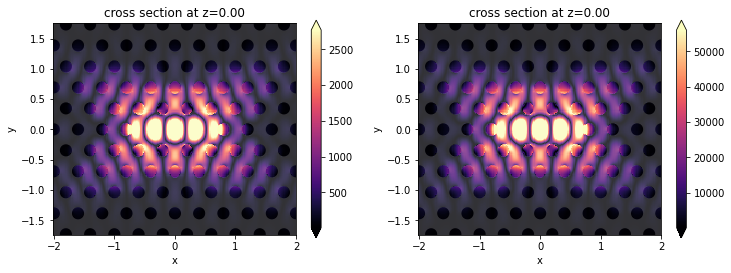

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sim_data.plot_field('final_time', 'Ey', val='abs', z=0, time=run_time, ax=ax[0])
sim_data.plot_field('field', 'Ey', val='abs', z=0, freq=freq0, ax=ax[1]);